<a href="https://colab.research.google.com/github/veyselberk88/Data-Science-Tools-and-Ecosystem/blob/main/lec35.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

<img src="./ccsf.png" alt="CCSF Logo" width=200px style="margin:0px -5px">

# Lecture 35: Regression Inference

Associated Textbook Sections: [16.0 - 16.3](https://ccsf-math-108.github.io/textbook/chapters/16/Inference_for_Regression.html)

---

## Outline

* [Regression Model](#Regression-Model)
* [Prediction Variability](#Prediction-Variability)
* [The True Slope](#The-True-Slope)

---

## Set Up the Notebook

In [ ]:
from datascience import *
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt
plt.style.use('fivethirtyeight')

def draw_and_compare(true_slope, true_int, sample_size):
    x = np.random.normal(50, 5, sample_size)
    xlims = np.array([np.min(x), np.max(x)])
    errors = np.random.normal(0, 6, sample_size)
    y = (true_slope * x + true_int) + errors
    sample = Table().with_columns('x', x, 'y', y)

    sample.scatter('x', 'y')
    plt.plot(xlims, true_slope*xlims + true_int, lw=2, color='green')
    plt.title('True Line, and Points Created')

    sample.scatter('x', 'y')
    plt.title('What We Get to See')

    sample.scatter('x', 'y', fit_line=True)
    plt.title('Regression Line: Estimate of True Line')

    sample.scatter('x', 'y', fit_line=True)
    plt.plot(xlims, true_slope*xlims + true_int, lw=2, color='green')
    plt.title("Regression Line and True Line")

def standard_units(arr):
    return (arr - np.average(arr))/np.std(arr)

def correlation(t, x, y):
    x_standard = standard_units(t.column(x))
    y_standard = standard_units(t.column(y))
    return np.average(x_standard * y_standard)

def slope(t, x, y):
    r = correlation(t, x, y)
    y_sd = np.std(t.column(y))
    x_sd = np.std(t.column(x))
    return r * y_sd / x_sd

def intercept(t, x, y):
    x_mean = np.mean(t.column(x))
    y_mean = np.mean(t.column(y))
    return y_mean - slope(t, x, y)*x_mean

def fitted_values(t, x, y):
    """Return an array of the regression estimates at all the x values"""
    a = slope(t, x, y)
    b = intercept(t, x, y)
    return a*t.column(x) + b

def residuals(t, x, y):
    predictions = fitted_values(t, x, y)
    return t.column(y) - predictions

def add_regression_to_table(t, x, y):
    """ Returns a new table with 'Fitted value' and 'Residual' columns added """
    t_with_extra_cols = t.with_columns(
        'Fitted value', fitted_values(t, x, y),
        'Residual', residuals(t, x, y)
    )
    return t_with_extra_cols

---

## Regression Model

---

### A "Model": Signal + Noise

<img src="./signal_noise.png" width=80%>

---

### What We Get To See

<img src="./what_we_see.png" width=50%>

---

### Demo: Regression Model

Explore a few examples showing the true line, the points created, and the line produced from the sample.

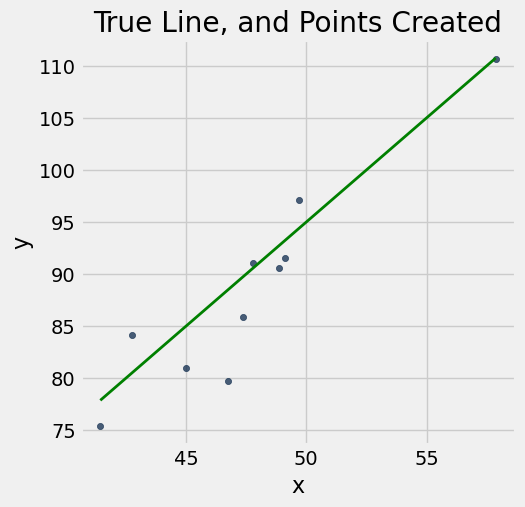

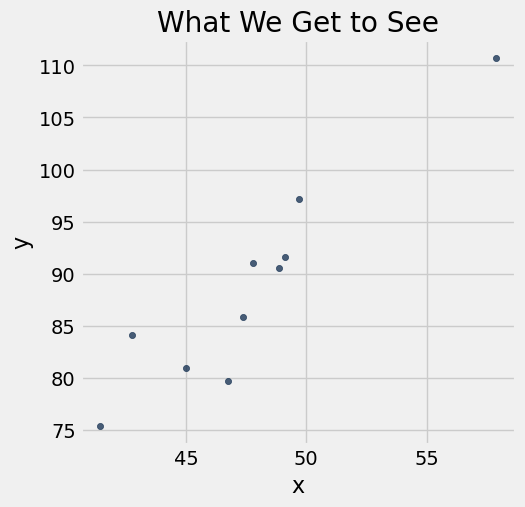

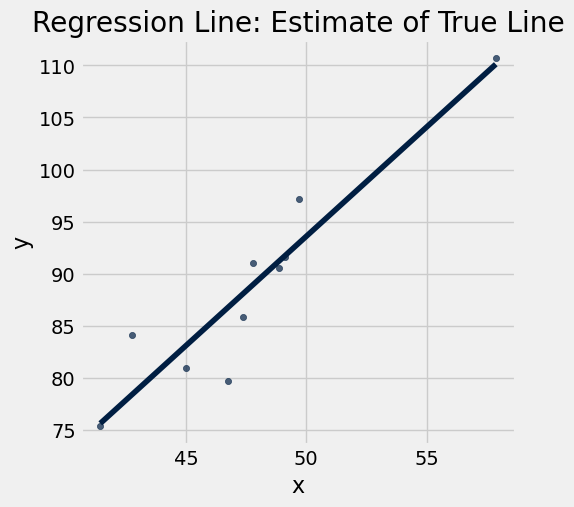

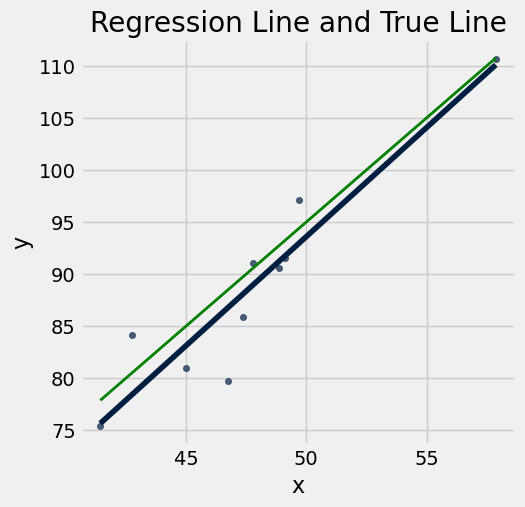

In [ ]:
draw_and_compare(2, -5, 10)

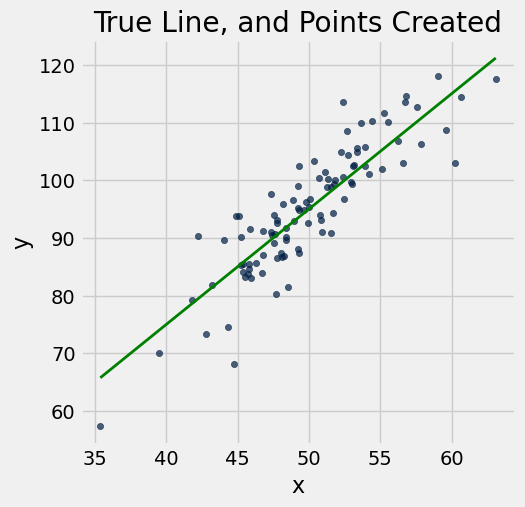

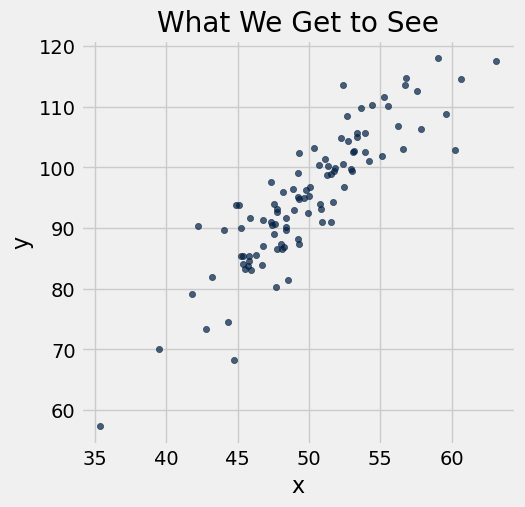

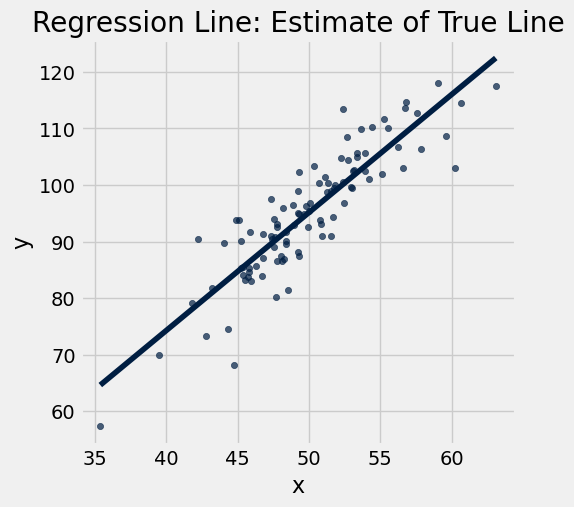

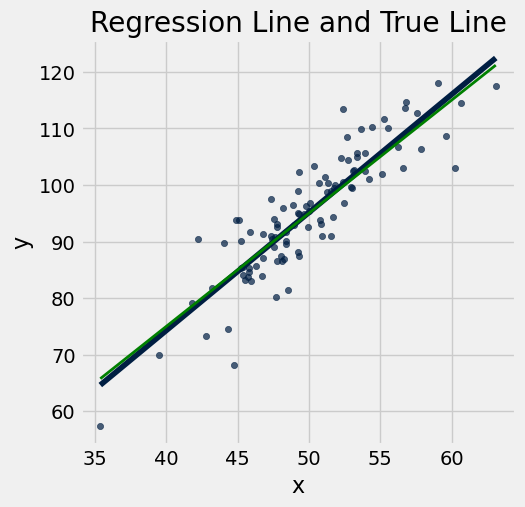

In [ ]:
draw_and_compare(2, -5, 100)

---

## Prediction Variability

---

### Regression Prediction

If the data come from the regression model:
* The "true value" of the response $y$ at a given value of $x$ is the height of the true line at $x$
* We can't see the true line, so we have to estimate this height
* The regression line is most likely close to the true line
* Given a new value of $x$, predict $y$ by finding the point on the regression line at that $x$.

---

### Demo: Prediction

Explore the variability in the linear regression prediction of `Birth Weight` based on `Gestational Days` using the `baby.csv` dataset.

In [ ]:
births = Table.read_table('baby.csv')
births.show(3)

Birth Weight,Gestational Days,Maternal Age,Maternal Height,Maternal Pregnancy Weight,Maternal Smoker
120,284,27,62,100,False
113,282,33,64,135,False
128,279,28,64,115,True


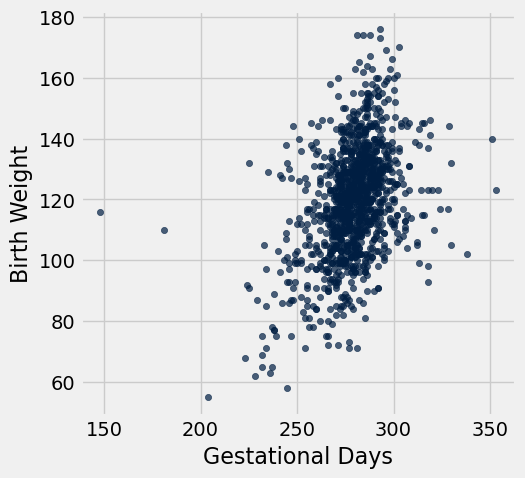

In [ ]:
births.scatter('Gestational Days', 'Birth Weight')

In [ ]:
# Define data in the top or bottom 2.5 percentile as outliers
percentile_2_5 = percentile(2.5, births.column('Gestational Days'))
percentile_97_5 = percentile(97.5, births.column('Gestational Days'))
print(f'The middle 95% of the gestational days are \
between {percentile_2_5} days and {percentile_97_5} days.')

The middle 95% of the gestational days are between 243 days and 308 days.


In [ ]:
births = births.where('Gestational Days', are.between(243, 308))


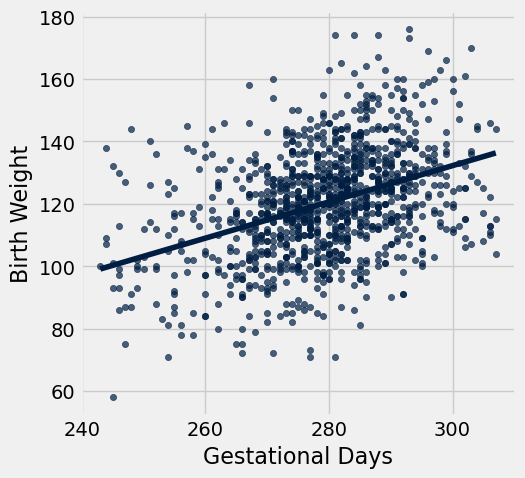

In [ ]:
births.scatter('Gestational Days', 'Birth Weight', fit_line=True)

In [ ]:
def prediction_at(t, x, y, x_value):
    '''
    t - table
    x - label of x column
    y - label of y column
    x_value - the x value for which we want to predict y
    '''
    return slope(t, x, y) * x_value + intercept(t, x, y)

In [ ]:
prediction_at_300 = prediction_at(births, 'Gestational Days', 'Birth Weight', 300)

prediction_at_300

132.20401082436854

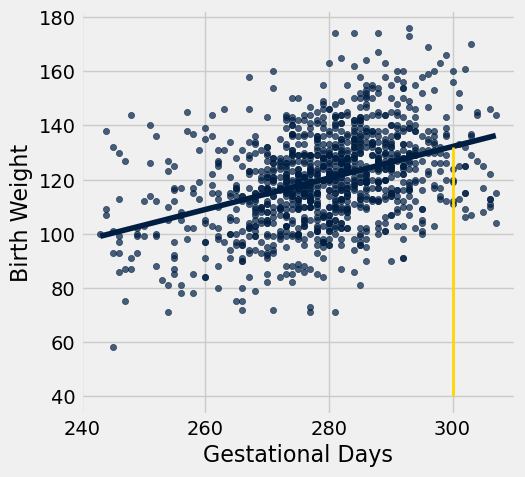

In [ ]:
x = 300
births.scatter('Gestational Days', 'Birth Weight', fit_line=True)
plt.plot([x, x], [40, prediction_at_300], color='gold', lw=2);

---

### Confidence Interval for Prediction

* Bootstrap the scatter plot
* Get a prediction for y using the regression line that goes through the resampled plot
* Repeat the two steps above many times
* Draw the empirical histogram of all the predictions.
* Get the "middle 95%" interval.
* That's an approximate 95% confidence interval for the height of the true line at y.

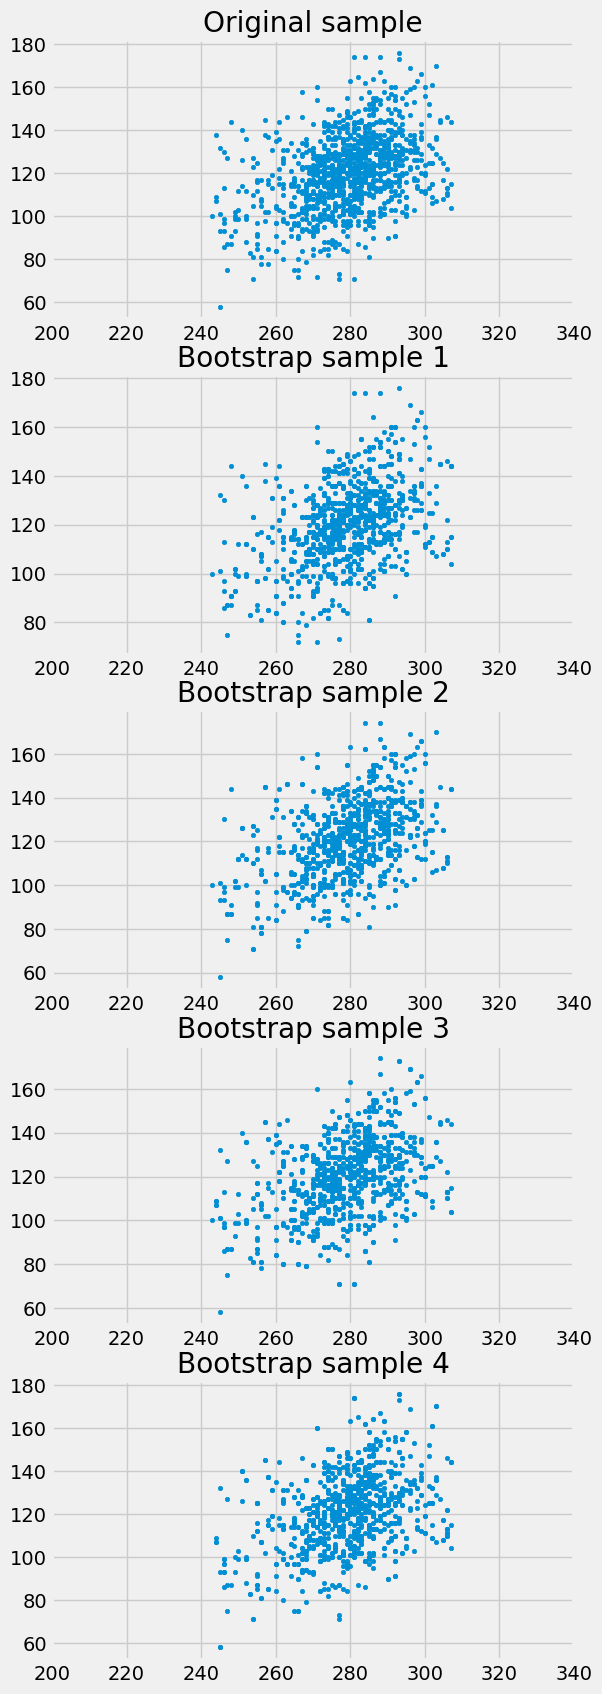

In [ ]:
plt.figure(figsize=(6, 20))
plt.subplot(5, 1, 1)
plt.scatter(births[1], births[0], s=10)
plt.xlim([200, 340])
plt.title('Original sample')

for i in np.arange(1, 5, 1):
    plt.subplot(5,1,i+1)
    rep = births.sample()
    plt.scatter(rep[1], rep[0], s=10)
    plt.xlim([200, 340])
    plt.title('Bootstrap sample '+str(i))

Predicted y from bootstramp sample was 134.390744872
Predicted y from bootstramp sample was 132.257377181
Predicted y from bootstramp sample was 131.11476615
Predicted y from bootstramp sample was 133.151354306


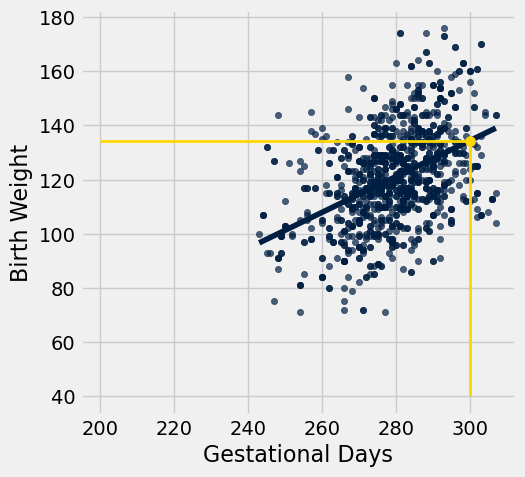

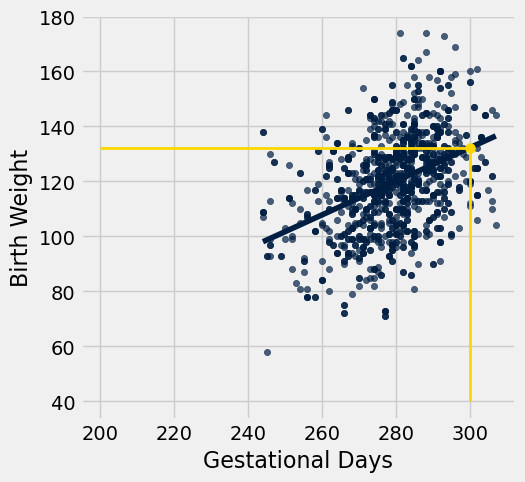

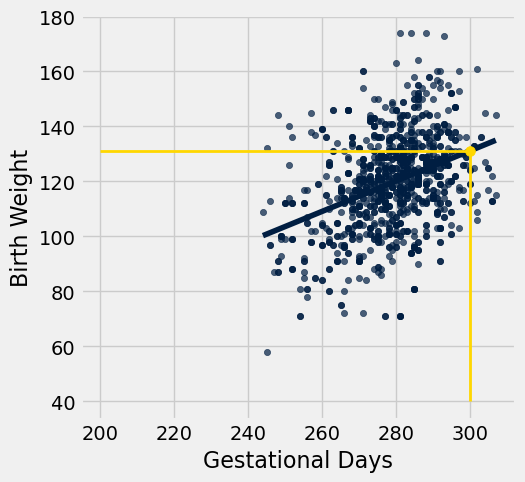

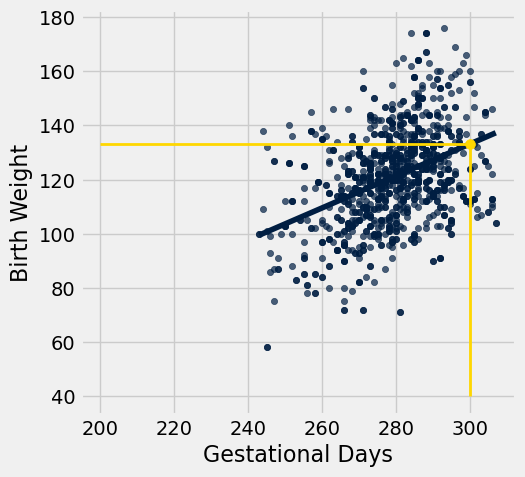

In [ ]:
for i in np.arange(4):
    resample = births.sample()
    predicted_y = prediction_at(resample, 'Gestational Days', 'Birth Weight', 300)
    print('Predicted y from bootstramp sample was', predicted_y)
    resample.scatter('Gestational Days', 'Birth Weight', fit_line=True)
    plt.scatter(300, predicted_y, color='gold', s=50, zorder=3);
    plt.plot([x, x], [40, predicted_y], color='gold', lw=2);
    plt.plot([200, x], [predicted_y, predicted_y], color='gold', lw=2);

---

Observe the variation in the regression lines made from each sample.

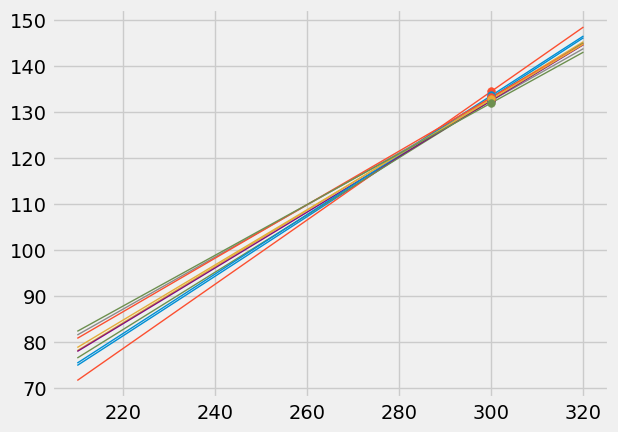

In [ ]:
lines = Table(['slope','intercept', 'at 210', 'at 300', 'at 320'])

for i in range(10):
    resample = births.sample()
    a = slope(resample, 'Gestational Days', 'Birth Weight')
    b = intercept(resample, 'Gestational Days', 'Birth Weight')
    lines.append([a, b, a * 210 + b, a * 300 + b, a * 320 + b])

for i in np.arange(lines.num_rows):
    line = lines.row(i)
    plt.plot([210, 320], [line.item('at 210'), line.item('at 320')], lw=1)
    plt.scatter(300, line.item('at 300'), s=30, zorder=3)

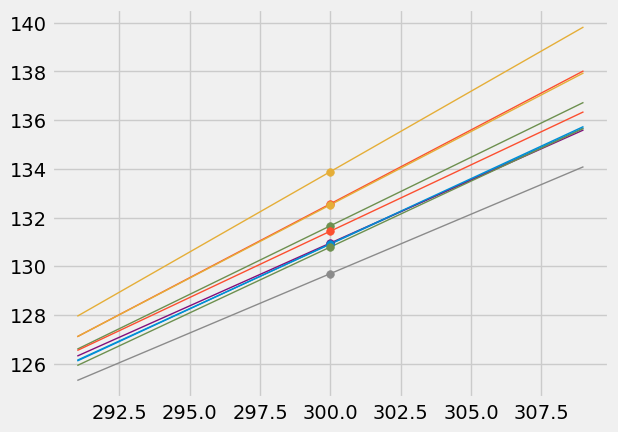

In [ ]:
lines = Table(['slope','intercept', 'at 291', 'at 300', 'at 309'])

for i in range(10):
    resample = births.sample()
    a = slope(resample, 'Gestational Days', 'Birth Weight')
    b = intercept(resample, 'Gestational Days', 'Birth Weight')
    lines.append([a, b, a * 291 + b, a * 300 + b, a * 309 + b])

for i in np.arange(lines.num_rows):
    line = lines.row(i)
    plt.plot([291, 309], [line.item('at 291'), line.item('at 309')], lw=1)
    plt.scatter(300, line.item('at 300'), s=30, zorder=3)

---

### Demo: Confidence Interval for Prediction

Construct a confidence interval for the height of the true line.

In [ ]:
def bootstrap_prediction(t, x, y, new_x, repetitions=1000):

    # Bootstrap the scatter, predict, collect
    predictions = make_array()
    for i in np.arange(repetitions):
        resample = t.sample()
        predicted_y = prediction_at(resample, x, y, new_x)
        predictions = np.append(predictions, predicted_y)

    # Find the ends of the approximate 95% prediction interval
    left = percentile(2.5, predictions)
    right = percentile(97.5, predictions)

    # Display results
    Table().with_column('Prediction', predictions).hist(bins=20)
    plt.xlabel('predictions at x='+str(new_x))
    plt.plot([left, right], [0, 0], color='yellow', lw=8);
    print('Approximate 95%-confidence interval for height of true line:')
    print(left, right, '(width =', right - left, ')')

Approximate 95%-confidence interval for height of true line:
130.044769523 134.300974496 (width = 4.25620497302 )


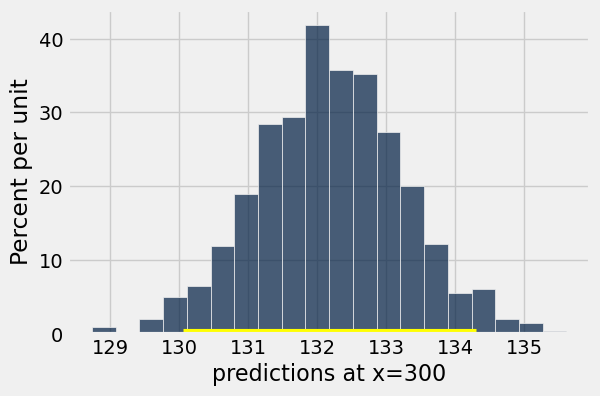

In [ ]:
bootstrap_prediction(births, 'Gestational Days', 'Birth Weight', 300)

---

### Predictions at Different Values of $x$

* Since $y$ is correlated with $x$, the predicted values of $y$ depend on the value of $x$.
* The width of the prediction's CI also depends on $x$.
* Typically, intervals are wider for values of $x$ that are further away from the mean of $x$.

---

### Demo: Predictions at Different Values of $x$

Explore predictions made for different values of $x$.

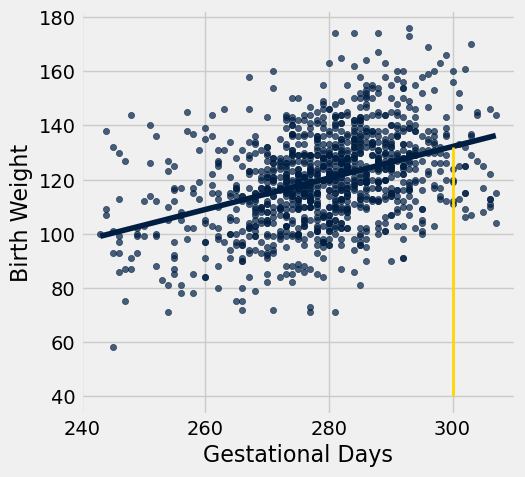

In [ ]:
x = 300
births.scatter('Gestational Days', 'Birth Weight', fit_line=True)
plt.plot([x, x], [40, prediction_at_300], color='gold', lw=2);

Approximate 95%-confidence interval for height of true line:
96.9842423422 103.18324728 (width = 6.19900493822 )


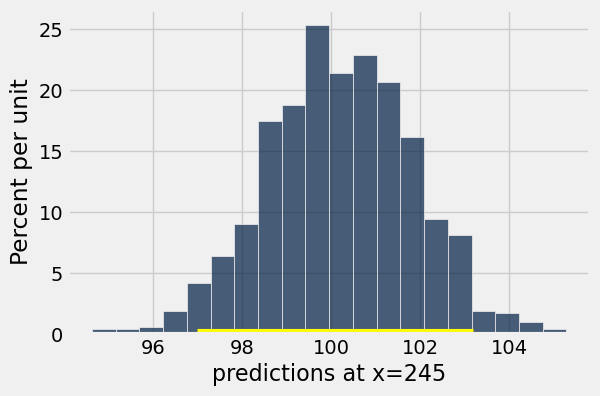

In [ ]:
bootstrap_prediction(births, 'Gestational Days', 'Birth Weight', 245)

Approximate 95%-confidence interval for height of true line:
119.704560391 121.564605858 (width = 1.86004546743 )


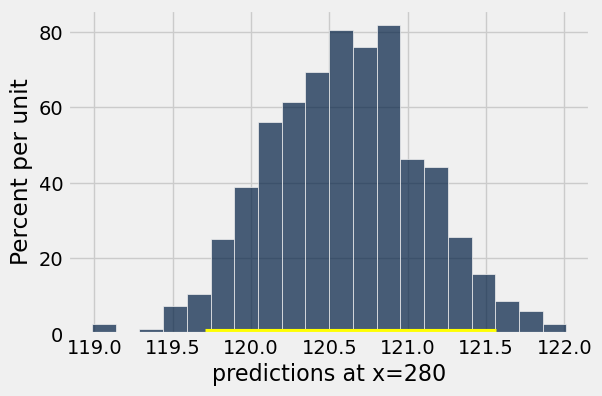

In [ ]:
bootstrap_prediction(births, 'Gestational Days', 'Birth Weight', 280)

In [ ]:
np.mean(births.column('Gestational Days'))

279.22212230215825

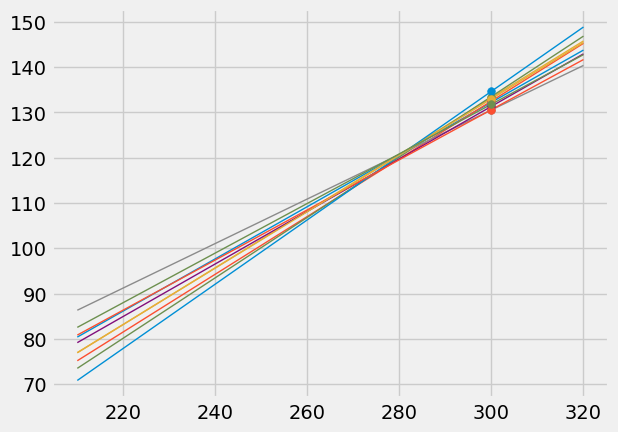

In [ ]:
lines = Table(['slope','intercept', 'at 210', 'at 300', 'at 320'])

for i in range(10):
    resample = births.sample()
    a = slope(resample, 'Gestational Days', 'Birth Weight')
    b = intercept(resample, 'Gestational Days', 'Birth Weight')
    lines.append([a, b, a * 210 + b, a * 300 + b, a * 320 + b])

for i in np.arange(lines.num_rows):
    line = lines.row(i)
    plt.plot([210, 320], [line.item('at 210'), line.item('at 320')], lw=1)
    plt.scatter(300, line.item('at 300'), s=30, zorder=3)

---

## The True Slope

---

### Confidence Interval for True Slope

* Bootstrap the scatter plot.
* Find the slope of the regression line through the bootstrapped plot.
* Repeat.
* Draw the empirical histogram of all the generated slopes.
* Get the "middle 95%" interval.
* That's an approximate 95% confidence interval for the slope of the true line.


---

### Demo: Inference for the Slope

Provide a 95\% confidence interval for the slope of the true regression line relating Gestational Days and Birth Weight.

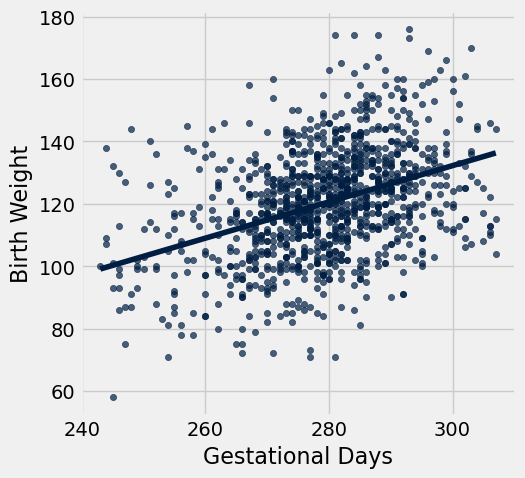

In [ ]:
births.scatter('Gestational Days', 'Birth Weight', fit_line=True)

In [ ]:
slope(births, 'Gestational Days', 'Birth Weight')

0.58108028724076277

In [ ]:
def bootstrap_slope(t, x, y, repetitions=5000):

    # Bootstrap the scatter, find the slope, collect
    slopes = make_array()
    for i in np.arange(repetitions):
        bootstrap_sample = t.sample()
        bootstrap_slope = slope(bootstrap_sample, x, y)
        slopes = np.append(slopes, bootstrap_slope)

    # Find the endpoints of the 95% confidence interval for the true slope
    left = percentile(2.5, slopes)
    right = percentile(97.5, slopes)

    # Slope of the regression line from the original sample
    observed_slope = slope(t, x, y)

    # Display results
    Table().with_column('Bootstrap Slopes', slopes).hist(bins=20)
    plt.plot(make_array(left, right), make_array(0, 0), color='yellow', lw=8);
    print('Slope of regression line:', observed_slope)
    print('Approximate 95%-confidence interval for the slope of the true line:')
    print(left, 'to', right)

Slope of regression line: 0.581080287241
Approximate 95%-confidence interval for the slope of the true line:
0.493993640454 to 0.67107551693


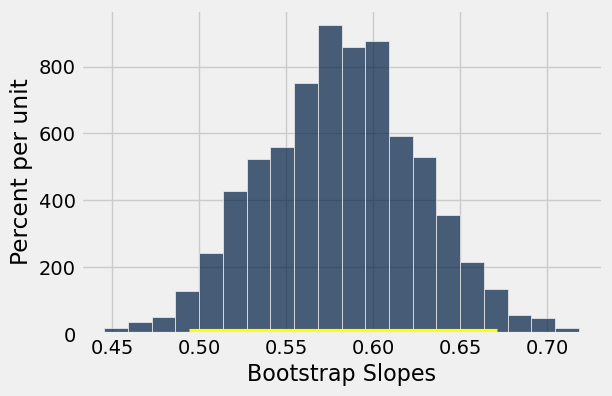

In [ ]:
bootstrap_slope(births, 'Gestational Days', 'Birth Weight', 2500)

---

### Rain on the Regression Parade

<img src="./rain.png" width=60%>

---

### Demo: Rain on the Regression Parade

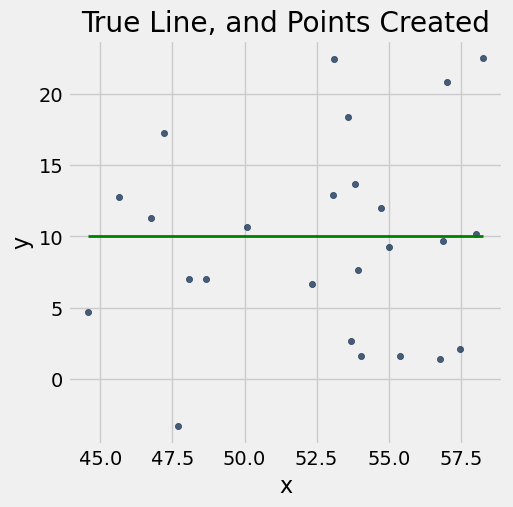

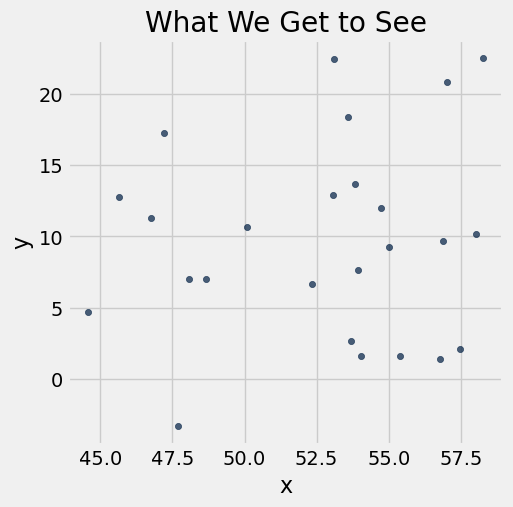

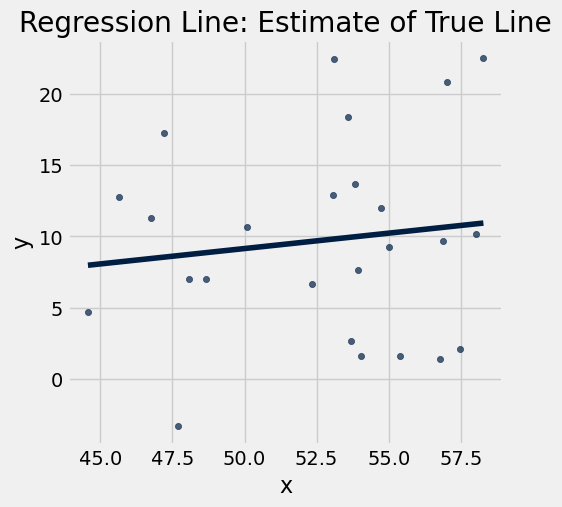

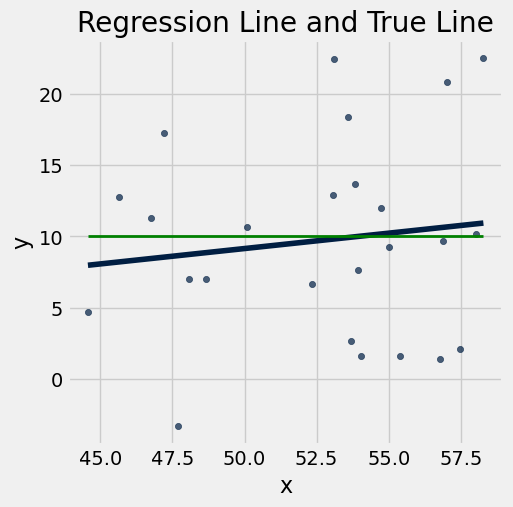

In [ ]:
draw_and_compare(0, 10, 25)

---

### Test Whether There Really is a Slope

* Null hypothesis: The slope of the true line is 0.
* Alternative hypothesis: No, it's not.
* Method:
    * Construct a bootstrap confidence interval for the true slope.
    * If the interval doesn't contain 0, the data are more consistent with the alternative
    * If the interval does contain 0, the data are more consistent with the null


---

### Demo: Test Whether There Really is a Slope

Test whether Maternal Age and Birth Weight are correlated using the following hypotheses:

**Null Hypothesis.** Slope of true line = 0.

**Alternative Hypothesis.** Slope of true line is not 0.

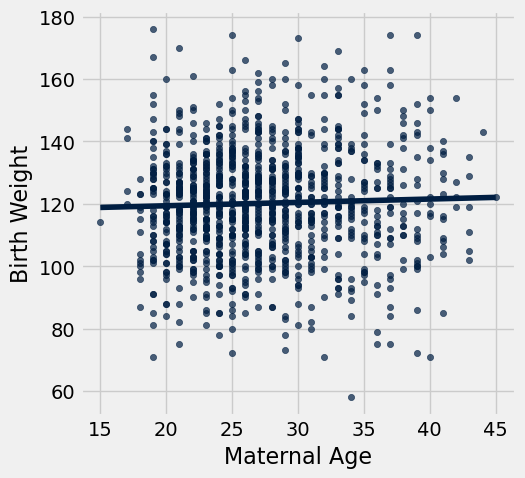

In [ ]:
births.scatter('Maternal Age', 'Birth Weight', fit_line=True)

In [ ]:
slope(births, 'Maternal Age', 'Birth Weight')

0.10747886260948702

Slope of regression line: 0.107478862609
Approximate 95%-confidence interval for the slope of the true line:
-0.0857530121897 to 0.289752644089


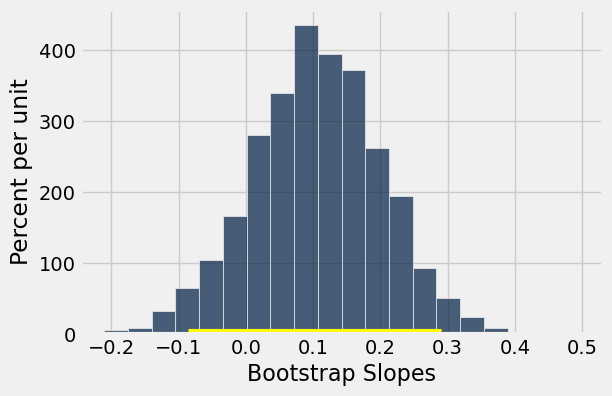

In [ ]:
bootstrap_slope(births, 'Maternal Age', 'Birth Weight', 2500)

---

## Attribution

This content is licensed under the <a href="https://creativecommons.org/licenses/by-nc-sa/4.0/">Creative Commons Attribution-NonCommercial-ShareAlike 4.0 International License (CC BY-NC-SA 4.0)</a> and derived from the <a href="https://www.data8.org/">Data 8: The Foundations of Data Science</a> offered by the University of California, Berkeley.

<img src="./by-nc-sa.png" width=100px>